# Análisis de Interconnect

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

## Trabajo previo

### Importar librerías

In [1]:
# Importamos los módulos necesarios
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Para trabajar mejor
import typing
from re import sub

### Trabajar con los datos

#### Cargar los datasets

In [2]:
# Creemos dataframes para los valores que tenemos
df_contract = pd.read_csv("data/contract.csv")
df_internet = pd.read_csv("data/internet.csv")
df_personal = pd.read_csv("data/personal.csv")
df_phone = pd.read_csv("data/phone.csv")


In [3]:
# Mostremos la info de los dataframes que tenemos
df_contract.info()
df_internet.info()
df_personal.info()
df_phone.info()

# Estos nos servirá después para limpiar
dataframe_list = [df_contract, df_internet, df_personal, df_phone]
dataframe_list_keys = ["df_contract", "df_internet", "df_personal", "df_phone"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-nu

Parece que no tenemos nulos, pero no necesariamente todos los valores tengan sentido, así que tendremos echar un vistazo a ellos. Por otro lado, pueden existir duplicados y  los nombres de columnas no siguen el formato de _snake case_ así que tendremos que cambiarlos; empecemos con esto último.

#### Cambio de nombres de columnas

In [4]:
# Definamos una función para esto
def snake_caser(var_string: str) -> str:
    return sub(r'([a-z](?=[A-Z])|[A-Z](?=[A-Z][a-z]))', r'\1_',var_string).lower()

def snake_caser_list(input_list: list) -> list:
    return [snake_caser(item) for item in input_list]


In [5]:
# Aplicamos
for df in dataframe_list:
    df.columns = snake_caser_list(df.columns)
    print(df.columns)

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')
Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')
Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')
Index(['customer_id', 'multiple_lines'], dtype='object')


Se ve mucho mejor, tener las columnas con el nombre apropiado es muy útil para trabajar. Prosigamos a ver si existen duplicados por el customer_id.

#### Revisión de duplicados

In [6]:
# Veamos duplicados por customer_id
print("Duplicados")

for df, key in zip(dataframe_list, dataframe_list_keys):
    print(
        key,": ", len(df[df.duplicated(subset="customer_id")])
    )

Duplicados
df_contract :  0
df_internet :  0
df_personal :  0
df_phone :  0


No tenemos duplicados, ahora echaremos un vistazo rápido a una muestra de elementos de cada dataset para ver que tenemos en cada dataset.

#### Vistazo general de samples

In [7]:
for df, key in zip(dataframe_list, dataframe_list_keys):
    print(key)
    display(
        df.sample(n=10, random_state=12345)
    )
    print()

df_contract


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
1128,0098-BOWSO,2017-11-01,No,Month-to-month,Yes,Electronic check,19.40,529.8
2875,9992-RRAMN,2018-02-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,85.10,1873.7
1783,8380-PEFPE,2019-09-01,2019-10-01 00:00:00,Month-to-month,Yes,Electronic check,71.65,71.65
3804,9773-PEQBZ,2019-04-01,No,Month-to-month,No,Electronic check,79.85,797.25
6087,8319-QBEHW,2017-12-01,No,One year,Yes,Bank transfer (automatic),39.95,1023.75
2071,3392-EHMNK,2014-07-01,No,Two year,No,Credit card (automatic),94.10,6302.8
2395,6486-LHTMA,2017-07-01,No,One year,Yes,Electronic check,90.70,2835.5
4660,0883-EIBTI,2019-10-01,2019-12-01 00:00:00,Month-to-month,No,Mailed check,19.50,31.55
372,6122-EFVKN,2018-02-01,No,Two year,No,Mailed check,35.75,830.8
1143,2446-ZKVAF,2018-08-01,No,Month-to-month,No,Credit card (automatic),56.80,1074.65



df_internet


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
4878,7823-JSOAG,Fiber optic,No,No,No,No,No,No
5002,4450-YOOHP,DSL,No,No,Yes,No,Yes,Yes
4160,2498-XLDZR,DSL,Yes,Yes,Yes,Yes,No,Yes
683,7905-TVXTA,DSL,Yes,No,No,Yes,Yes,No
1930,9802-CAQUT,Fiber optic,Yes,Yes,Yes,No,Yes,Yes
2140,3387-VATUS,Fiber optic,No,No,No,No,Yes,Yes
2311,2845-AFFTX,Fiber optic,No,No,Yes,No,Yes,Yes
3417,0853-NWIFK,Fiber optic,Yes,Yes,No,No,Yes,Yes
1472,0973-KYVNF,DSL,Yes,Yes,Yes,No,Yes,No
4716,9253-QXKBE,Fiber optic,No,No,No,No,Yes,Yes



df_personal


,customer_id,gender,senior_citizen,partner,dependents
1128,0098-BOWSO,Male,0,No,No
2875,9992-RRAMN,Male,0,Yes,No
1783,8380-PEFPE,Male,0,No,Yes
3804,9773-PEQBZ,Male,0,No,No
6087,8319-QBEHW,Male,0,No,Yes
2071,3392-EHMNK,Female,0,Yes,Yes
2395,6486-LHTMA,Female,1,Yes,No
4660,0883-EIBTI,Female,0,No,No
372,6122-EFVKN,Male,0,No,Yes
1143,2446-ZKVAF,Male,0,Yes,No



df_phone


,customer_id,multiple_lines
1649,8966-KZXXA,Yes
1920,7206-PQBBZ,No
2852,4567-AKPIA,Yes
911,7047-YXDMZ,No
6259,7619-PLRLP,Yes
3581,1304-NECVQ,Yes
5992,9248-OJYKK,Yes
3169,2921-XWDJH,No
3903,9134-WYRVP,No
121,3774-VBNXY,No


Verificaremos que la información esta integra y que no tengamos typos (por ejemplo yes en vez de Yes). 

#### Revisión de datos y cambio de tipos

Iremos tabla por tabla, empezamos con `df_phone`.

In [8]:
df_phone.describe()

,customer_id,multiple_lines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


Todo se ve bien, podemos continuar con `df_personal`.

In [9]:
# Removemos customer_id ya que esos son únicos.
for item in df_personal.drop("customer_id", axis=1).columns:
    print(df_personal[item].unique())

['Female' 'Male']
[0 1]
['Yes' 'No']
['No' 'Yes']


Igual, prosigamos a `df_internet`:

In [10]:
# Removemos customer_id ya que esos son únicos.
for item in df_internet.drop("customer_id", axis=1).columns:
    print(df_internet[item].unique())

['DSL' 'Fiber optic']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']


Todo bien, vamos finalmente a `df_contract`.

In [11]:
# Removemos customer_id y los cargos
for item in df_contract.drop(["customer_id", "monthly_charges", "total_charges"], axis=1).columns:
    print(df_contract[item].unique())

['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2018-11-01' '2015-03-01' '2018-02-01'
 '2016-06-01' '2015-08-01' '2015-11-01' '2014-06-01' '2017-01-01'
 '2015-07-01' '2020-02-01' '2016-11-01' '2013-11-01' '2014-01-01'
 '2013-10-

No hay typos, sin embargo podemos mejorar nuestro trabajo convirtiendo las fechas en objeto fecha. Aquí sin embargo, tenemos un problema: mientrás que para `begin_date` todos los valores son fechas, para `end_date` tenemos el valor _No_, por lo que haremos algo con esto, crearemos una nueva columna llamada `end_service` que será Yes/No y removeremos los No de la columna para poder convertir al tipo datos.

In [12]:
# Para begin_date sin problemas
df_contract.begin_date = df_contract.begin_date.astype("datetime64[ns]")

# Creamos la nueva columna
df_contract["end_service"] = df_contract.end_date.apply(lambda value: "No" if value == "No" else "Yes")

# Removamos los no y cambiemos el tipo
df_contract.end_date = df_contract.end_date.apply(lambda value: "" if value == "No" else value)
df_contract.end_date = df_contract.end_date.astype("datetime64[ns]")

# Mostremos un info para verificar todo
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
 8   end_service        7043 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 495.3+ KB


Se ve mucho mejor, el hecho de que `end_date` tenga poco menos de 2000 no nulos se debe a que los otros no cancelarán el servicio.

### Merge de los datasets
Como ya hemos limpiado todos los datasets, podemos aprovechar que tenemos datos únicos para hacer el merge entre ellos usando `customer_id` como una llave.

In [13]:
df_merged = df_contract.merge(df_personal).merge(df_phone, "left").merge(df_internet, "left").reset_index(drop=True)

df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
 8   end_service        7043 non-null   object        
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   int64         
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
 13  multiple_lines     6361 non-null   object        
 14  internet

Tenemos bastantes nulos porque no todos los usuarios tienen los mismos servicios contratados (por ejemplo quien haya contratado internet sin línea telefónica tendrá vacíos los campos de `multiple_lines`). Para ayudarnos a hacer nuestro análisis, crearemos una nueva columna `services`, la cual indicará si el usuario tiene _phone_, _internet_ o _both_ (ambos). Antes de eso, llenaremos los nulos de las columnas con "NA" para que no sean nulos (a excepción de end_date).

In [14]:
# Lista de columnas a fill
columns_to_fill = list(df_internet.columns)
columns_to_fill.append("multiple_lines")

columns_to_fill.pop(0)
columns_to_fill

# Llenamos
df_merged[columns_to_fill] = df_merged[columns_to_fill].fillna("NA")

Ahora sí, hacemos la nueva columna.

In [15]:
def service_classifier(row):
    if row.multiple_lines == "NA":
        return "Internet"
    elif row.internet_service == "NA":
        return "Phone"
    else:
        return "Both"
        
df_merged["service"] = df_merged.apply(service_classifier, axis=1)

Veamos un pequeño sample de que tenemos para terminar.

In [16]:
df_merged.sample(n=5, random_state=12345)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,end_service,gender,...,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,service
1128,0098-BOWSO,2017-11-01,NaT,Month-to-month,Yes,Electronic check,19.40,529.8,No,Male,...,No,No,NA,NA,NA,NA,NA,NA,NA,Phone
2875,9992-RRAMN,2018-02-01,2019-12-01,Month-to-month,Yes,Electronic check,85.10,1873.7,Yes,Male,...,No,Yes,Fiber optic,No,No,No,No,No,Yes,Both
1783,8380-PEFPE,2019-09-01,2019-10-01,Month-to-month,Yes,Electronic check,71.65,71.65,Yes,Male,...,Yes,No,Fiber optic,No,No,No,No,No,No,Both
3804,9773-PEQBZ,2019-04-01,NaT,Month-to-month,No,Electronic check,79.85,797.25,No,Male,...,No,Yes,Fiber optic,No,Yes,No,No,No,No,Both
6087,8319-QBEHW,2017-12-01,NaT,One year,Yes,Bank transfer (automatic),39.95,1023.75,No,Male,...,Yes,NA,DSL,No,Yes,No,No,Yes,No,Internet


## Análisis exploratorio de datos

Veamos primero como se dividen los usuarios que siguen y los que han abandonado el servicio.

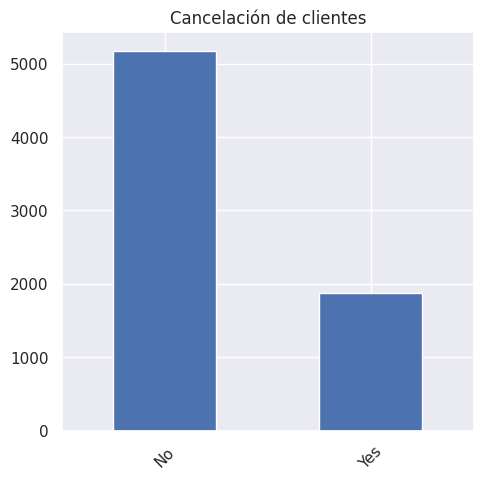

In [44]:
# Usamos set para estar más atractivo
sns.set_theme()
# Ploteamos
df_merged.end_service.value_counts().plot(kind="bar", figsize=(5,5), rot=45)

plt.tight_layout()
plt.xlabel("")
plt.title("Cancelación de clientes")
plt.show()

Tenemos un poco más de 5000 clientes que no han cancelado con casi 2000 que si lo han hecho: una relación de 2 a 5, o sea ~28% del total ha cancelado: es importante buscar una manera de reducir esas métricas. Veamos ahora como se distribuyen en el tipo de servicio que han contratado (internet, telefonía o ambos) y por la forma de facturación.

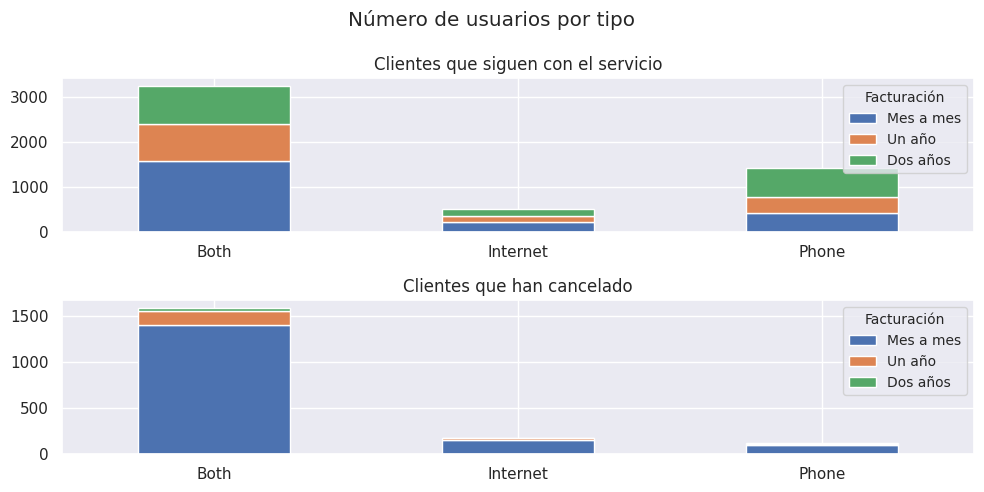

In [182]:
fig, ax = plt.subplots(2,1, figsize=(10, 5))

# New queries
df_no_end_service = df_merged.query("end_service == 'No'")
df_yes_end_service = df_merged.query("end_service == 'Yes'")

#df_merged.query("end_service == 'No'").service.value_counts(normalize=True).plot(kind="bar", ax=ax[0], rot=0)
df_no_end_service.groupby(["service", "type"]).size().unstack().plot(kind="bar", stacked=True, rot=0, ax=ax[0], )

#df_merged.query("end_service == 'Yes'").service.value_counts(normalize=True).plot(kind="bar", ax=ax[1], rot=0)
df_yes_end_service.groupby(["service", "type"]).size().unstack().plot(kind="bar", stacked=True, rot=0, ax=ax[1])

plt.suptitle("Número de usuarios por tipo")

# Embellecemos
for ii in [0,1]:
    ax[ii].set_xlabel("")
    ax[ii].legend(["Mes a mes", "Un año", "Dos años"], title="Facturación", fontsize='small', title_fontsize="small", loc=1)

ax[0].set_title("Clientes que siguen con el servicio")
ax[1].set_title("Clientes que han cancelado")

plt.tight_layout()
plt.show()

De esta figura se aprecia que la mayor cantidad de usuarios siempre es la que tiene ambos servicios contratados. Por el lado de los clientes que han cancelado es muy similar la proporción de los que usan internet contra celular, pero comparando con la de los usuarios que no cancelan podríamos aventurarnos a decir que la proporción de usuarios de internet que cancelan esta sobre representada y los que solo tienen teléfono cancelen menos de lo que uno esperaría. Por otro lado, es asombroso como se comportan los valores por el tipo de facturación: los usuarios que cancelan son principalmente de los que facturan mes a mes, esto puede deberse a no estar en un plazo forzoso. Ahora, también veamos como se comportan los usuarios según las fechas de inicio y de fin.

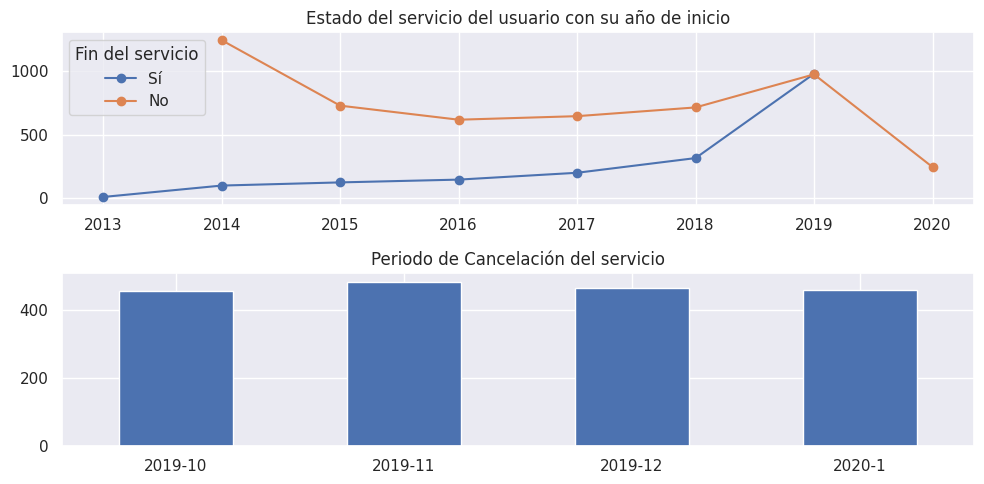

In [173]:
fig, ax = plt.subplots(2,1, figsize=(10, 5))

# Ploteamos begin date
df_yes_end_service.groupby(df_yes_end_service.begin_date.dt.year).begin_date.count().plot(
    kind="line", ax=ax[0], marker="o"
)

df_no_end_service.groupby(df_no_end_service.begin_date.dt.year).begin_date.count().plot(
    kind="line", ax=ax[0], marker="o"
)

ax[0].legend(["Sí", "No"], title="Fin del servicio")
ax[0].set_title("Estado del servicio del usuario con su año de inicio")
ax[0].set_xlabel("")

# Ploteamos end date para los que han cancelado
df_yes_end_service.end_date.value_counts().sort_index().reindex(["2019-10", "2019-11", "2019-12", "2020-1"]).plot(
    kind="bar", ax=ax[1], rot=0
)

ax[1].set_title("Periodo de Cancelación del servicio")
ax[1].set_xlabel("")

plt.tight_layout()
plt.show()

Interesante, de la primer gráfica es claro que los usuarios más antiguos tienden a permanecer en el servicio, mientrás que en fechas más recientes es donde se concentran los que cancelan: desde el 2018 son más comunes. Por otro lado, parece que en aquellos que cancelan, el periodo de cancelación es indiferente al mes: es casi idéntico en los valores que tenemos. Veamos ahora como se distribuye el costo mensual de los usuarios.

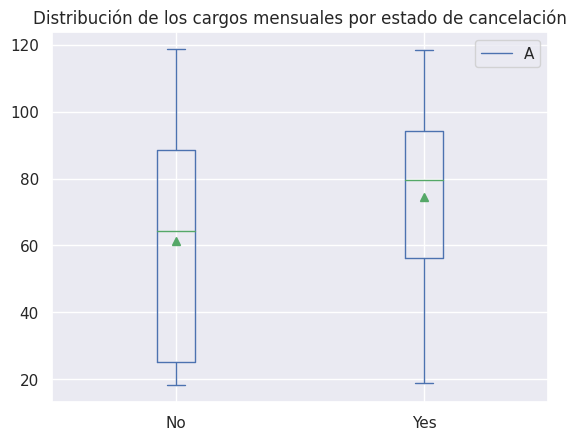

In [186]:
df_merged.plot(kind="box", column="monthly_charges", by="end_service", showmeans=True)

plt.legend("A")
plt.title("Distribución de los cargos mensuales por estado de cancelación")
plt.show()

La gráfica de la distribución de los cargos es simple, pero indica que aunque los mínimos y máximos se hallan en posiciones similares, más no los cuartiles, ya que para los que han cancelado es más cerrado el conjunto. Si esto se une a que la mediana (y la media, con el triángulo verde) es mayor en estos nos dice que los usuarios que han cancelado suelen pagar más mensualmente que los que no: esto podría explicar porque terminan su contrato. Mostremos ahora las características sociodemográficas de los usuarios.

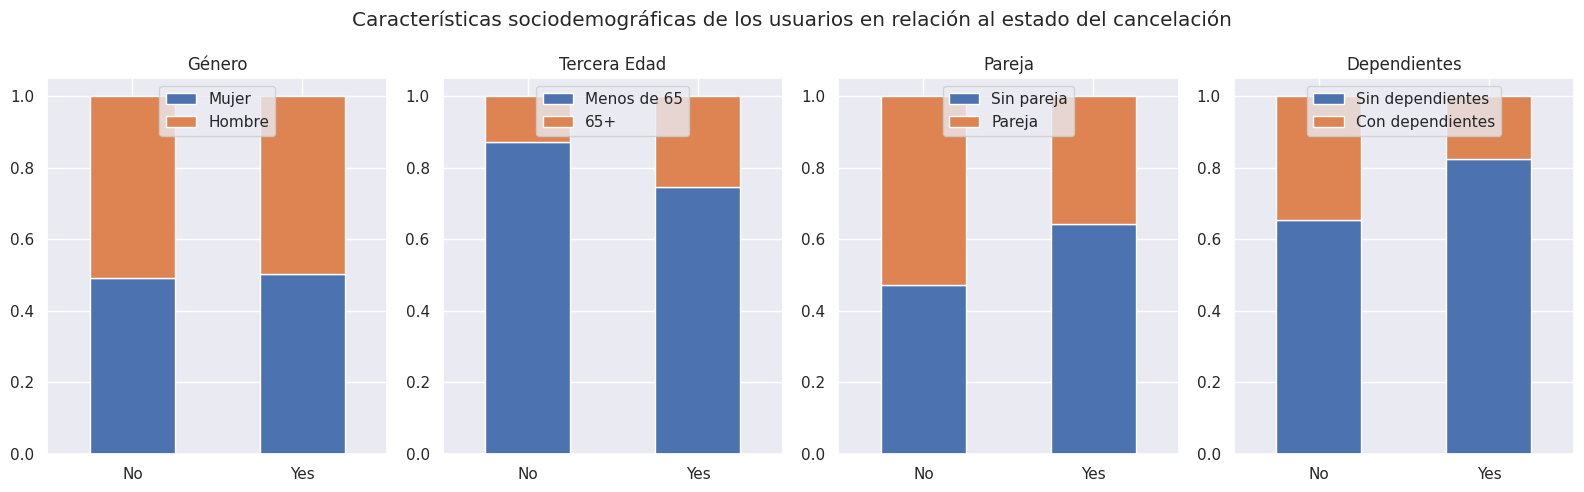

In [222]:
columns_sociodemografico = ["gender", "senior_citizen", "partner", "dependents"]
titulos = ["Género", "Tercera Edad", "Pareja", "Dependientes"]

# Ploteo
fig, ax = plt.subplots(1,4, figsize=(16, 5))

for column, count, title in zip(columns_sociodemografico, [0,1,2,3], titulos):
    df = df_merged.value_counts(["end_service", column], normalize=False).unstack()
    df.div(df.sum(axis=1), axis=0).plot(kind="bar", stacked=True, rot=0, ax=ax[count])
    ax[count].set_title(title)
    ax[count].set_xlabel("")

# Detalles varios
ax[0].legend(["Mujer", "Hombre"], loc=9)
ax[1].legend(["Menos de 65", "65+"], loc=9)
ax[2].legend(["Sin pareja", "Pareja"], loc=9)
ax[3].legend(["Sin dependientes", "Con dependientes"], loc=9)

plt.suptitle("Características sociodemográficas de los usuarios en relación al estado del cancelación")
plt.tight_layout()
plt.show()

Tenemos varios puntos importantes que mencionar: el género es indistinto en si cancelan o no, no parece haber relación; por otro lado, los usuarios de la tercera edad si parecen cancelar más que los de menor edad, tal vez por falta de uso; en el caso de la pareja sucede que los usuarios que cancelan suelen no tener pareja esto implicaría que debido a ser menos personas que comparten el gasto, no es costable: esto se refuerza con la columna de dependientes, ya que los usuarios que cancelan no suelen tenerlos y absorben el costo completo.